# Sentiment Analysis with Region Embeddings

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import tarfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
from sklearn.utils import shuffle
from math import ceil

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download data

Here we download the sentiment data from this [website](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz). These are movie reviews submitted by users classfied according to if it is a positive/negative sentiment.

In [2]:
url = 'http://ai.stanford.edu/~amaas/data/sentiment/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('aclImdb_v1.tar.gz', 84125825)

Found and verified aclImdb_v1.tar.gz


## Read data
Here the data is read into the program.

In [3]:
# Number of read files
files_read = 0

# Contains positive and negative sentiments
pos_members = []
neg_members = []

# Number of files to read
files_to_read = 400

# Creates a temporary directory to extract data to
if not os.path.exists('tmp_reviews'):
    os.mkdir('tmp_reviews')
    
def read_data(filename):
    """Extract the first file enclosed in a tar.z file as a list of words"""

    # Check if the directory is empty or not
    if os.listdir('tmp_reviews') == []:
        # If not empty read both postive and negative files upto
        # files_to_read many files and extract them to tmp_review folder
        with tarfile.open("aclImdb_v1.tar.gz") as t:
            for m in t.getmembers():
                # Extract positive sentiments and update files_read
                if 'aclImdb/train/pos' in m.name and '.txt' in m.name:
                    pos_members.append(m)
                    files_read += 1    
                    if files_read >= files_to_read:
                        break

                files_read = 0 # reset files_read
                # Extract negative sentiments and update files_read
                if 'aclImdb/train/neg' in m.name and '.txt' in m.name:
                    neg_members.append(m)
                    files_read += 1    
                    if files_read >= files_to_read:
                        break
            
            t.extractall(path='tmp_reviews',members=pos_members+neg_members)    
    
    print('Extracted (or already had) all data')
    
    # These lists will contain all the postive and negative
    # reviews we read above
    data = []
    data_sentiment, data_labels = [],[]
    
    print('Reading positive data')
    
    # Here we read all the postive data
    for file in os.listdir(os.path.join('tmp_reviews',*('aclImdb','train','pos'))):
        if file.endswith(".txt"):
            with open(os.path.join('tmp_reviews',*('aclImdb','train','pos',file)),'r',encoding='utf-8') as f:
                
                # Convert all the words to lower and tokenize
                file_string = f.read().lower()
                file_string = nltk.word_tokenize(file_string)
                
                # Add the words to data list
                data.extend(file_string)
                
                # If a review has more than 100 words truncate it to 100
                data_sentiment.append(file_string[:100])
                # If a review has less than 100 words add </s> tokens to make it 100
                if len(data_sentiment[-1])<100:
                    data_sentiment[-1].extend(['</s>' for _ in range(100-len(data_sentiment[-1]))])
                data_labels.append(1)
    
    print('Reading negative data')
    # Here we read all the negative data
    for file in os.listdir(os.path.join('tmp_reviews',*('aclImdb','train','neg'))):
        if file.endswith(".txt"):
            with open(os.path.join('tmp_reviews',*('aclImdb','train','neg',file)),'r',encoding='utf-8') as f:
                
                # Convert all the words to lower and tokenize
                file_string = f.read().lower()
                file_string = nltk.word_tokenize(file_string)
                # Add the words to data list
                data.extend(file_string)
                
                # If a review has more than 100 words truncate it to 100
                data_sentiment.append(file_string[:100])
                # If a review has less than 100 words add </s> tokens to make it 100
                if len(data_sentiment[-1])<100:
                    data_sentiment[-1].extend(['</s>' for _ in range(100-len(data_sentiment[-1]))])
                data_labels.append(0)
    return data, data_sentiment, data_labels
  
words, sentiments_words, sentiment_labels = read_data(filename)

# Print some statistics of the dta
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Extracted (or already had) all data
Reading positive data
Reading negative data
Data size 7054759
Example words (start):  ['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at']
Example words (end):  ['do', "n't", 'waste', 'your', 'time', ',', 'this', 'is', 'painful', '.']


## Building the Dictionaries
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words to are too rare to make use of.

In [4]:
# We set max vocabulary to this
vocabulary_size = 20000

def build_dataset(words):
  global vocabulary_size
  count = [['UNK', -1]]

  # Sorts words by their frequency
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
  # Define IDs for special tokens
  dictionary = dict({'<unk>':0, '</s>':1})
    
  # Crude Vocabulary Control
  # We ignore the most commone (words like a , the , ...)
  # and most rare (having a repetition of less than 10)
  # to reduce size of the vocabulary
  count_dict = collections.Counter(words)
  
  for word in words:  
    # Add the word to dictionary if already not encounterd
    if word not in dictionary:
        if count_dict[word]<50000 and count_dict[word] > 10:
            dictionary[word] = len(dictionary)

  data = list()
  unk_count = 0
    
  # Replacing word strings with word IDs
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count

  # Create a reverse dictionary with the above created dictionary
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  # Update the vocabulary
  vocabulary_size = len(dictionary)
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
# Print some statistics about the data
print('Most common words (+UNK)', count[:25])
print('Sample data', data[:10])
print('Vocabulary size: ',vocabulary_size)
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 2710699], ('the', 334680), (',', 275887), ('.', 235397), ('and', 163334), ('a', 162144), ('of', 145399), ('to', 135145), ('is', 110248), ('/', 102097), ('>', 102036), ('<', 101971), ('br', 101871), ('it', 94863), ('in', 93175), ('i', 86498), ('this', 75507), ('that', 72962), ("'s", 62159), ('was', 50367), ('as', 46818), ('for', 44050), ('with', 44001), ('movie', 42547), ('but', 42358)]
Sample data [0, 2, 0, 0, 3, 4, 0, 0, 5, 6]
Vocabulary size:  19908


## Processing data for the Region Embedding Learning

## Processing Data for the Sentiment Analysis
Here we define a function as well as run that function which converts the above words in the postive/negative reviews into word IDs.

In [5]:

def build_sentiment_dataset(sentiment_words, sentiment_labels):
  '''
  This function takes in reviews and labels, and then replace 
  all the words in the reviews with word IDs we assigned to each
  word in our dictionary
  '''
  data = [[] for _ in range(len(sentiment_words))]
  unk_count = 0
  for sent_id,sent in enumerate(sentiment_words):
    for word in sent:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
          unk_count = unk_count + 1
        data[sent_id].append(index)
  
  return data, sentiment_labels

# Run the operation
sentiment_data, sentiment_labels = build_sentiment_dataset(sentiments_words, sentiment_labels)
print('Sample data')
for rev in sentiment_data[:10]:
    print('\t',rev)

del sentiments_words  # Hint to reduce memory.

Sample data
	 [0, 2, 0, 0, 3, 4, 0, 0, 5, 6, 0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 16, 9, 17, 18, 19, 0, 20, 21, 22, 0, 0, 23, 24, 25, 26, 0, 27, 0, 0, 2, 0, 28, 0, 29, 30, 0, 31, 32, 0, 17, 18, 19, 0, 0, 0, 0, 33, 34, 0, 0, 35, 36, 37, 38, 39, 40, 41, 42, 43, 18, 44, 0, 0, 0, 0, 0, 0, 45, 46, 0, 47, 48, 26, 0, 0, 49, 0, 50, 0, 42, 36, 0, 51, 0, 52, 0, 53, 0, 54]
	 [0, 84, 85, 0, 9, 86, 87, 88, 89, 90, 91, 92, 93, 94, 22, 95, 96, 0, 97, 0, 98, 99, 100, 0, 101, 0, 102, 103, 104, 105, 37, 106, 107, 108, 109, 0, 14, 0, 110, 0, 85, 111, 94, 0, 112, 0, 113, 114, 77, 0, 0, 115, 9, 116, 0, 117, 118, 119, 120, 13, 121, 16, 9, 122, 0, 0, 123, 100, 124, 0, 0, 125, 0, 126, 0, 127, 0, 0, 0, 0, 0, 0, 85, 120, 128, 129, 130, 131, 132, 0, 133, 134, 100, 0, 0, 0, 0, 0, 0, 0]
	 [268, 269, 193, 0, 203, 204, 0, 270, 271, 0, 272, 0, 273, 274, 275, 0, 0, 229, 276, 0, 277, 278, 216, 279, 0, 280, 0, 0, 281, 100, 282, 0, 0, 63, 0, 9, 283, 9, 284, 0, 244, 245, 0, 0, 285, 100, 286, 0, 287, 288, 0, 194, 224, 28

## Data Generators

We define two data generators:
* Data generator for generating data for classifiers
* Data generator for generating data for region embedding algorithm


### Data Generator for Training Classifiers

Here we define a data generator function that generates data to train the classifier that identifies if a review is positive or negative

In [6]:
# Shuffle the data
sentiment_data, sentiment_labels = shuffle(sentiment_data, sentiment_labels)

sentiment_data_index = -1

def generate_sentiment_batch(batch_size, region_size,is_train):
  global sentiment_data_index

  # Number of regions in a single review
  # as a single review has 100 words after preprocessing
  num_r = 100//region_size 
    
  # Contains input data and output data
  batches = [np.ndarray(shape=(batch_size, vocabulary_size), dtype=np.int32) for _ in range(num_r)]
  labels = np.ndarray(shape=(batch_size), dtype=np.int32)

  # Populate each batch index
  for i in range(batch_size):
    # Choose a data point index, we use the last 300 reviews (after shuffling)
    # as test data and rest as training data
    if is_train:
      sentiment_data_index = np.random.randint(len(sentiment_data)-300)
    else:
      sentiment_data_index = max(len(sentiment_data)-300, (sentiment_data_index + 1)%len(sentiment_data))

    # for each region
    for reg_i in range(num_r):
        batches[reg_i][i,:] = np.zeros(shape=(1, vocabulary_size), dtype=np.float32) #input
        # for each word in region
        for wi in sentiment_data[sentiment_data_index][reg_i*num_r:(reg_i+1)*num_r]:

            # if the current word is informative (not <unk> or </s>)
            # Update the bow representation for that region
            if wi != dictionary['<unk>'] and wi != dictionary['</s>']:
              batches[reg_i][i,wi] += 1 

    labels[i] = sentiment_labels[sentiment_data_index]
        
  return batches, labels


# Print some data batches to see what they look like
for _ in range(10):
    batches, labels = generate_sentiment_batch(batch_size=8, region_size=10, is_train=True)
    
    print('    batch: sum: ', np.sum(batches[0],axis=1), np.argmax(batches[0],axis=1))
    print('    labels: ', labels)
    
print('\nValid data')

# Print some data batches to see what they look like
for _ in range(10):
    batches, labels = generate_sentiment_batch(batch_size=8, region_size=10, is_train=False)
    
    print('    batch: sum: ', np.sum(batches[0],axis=1), np.argmax(batches[0],axis=1))
    print('    labels: ', labels)
    
sentiment_data_index = -1 # Reset the index

    batch: sum:  [4 9 9 5 6 6 5 7] [264 108  22 165  80  74  71   9]
    labels:  [0 0 1 0 0 0 0 1]
    batch: sum:  [7 6 5 5 6 6 8 4] [ 108   80 3955 1660   55    6   17  385]
    labels:  [1 1 1 1 0 0 1 1]
    batch: sum:  [6 7 5 8 5 8 7 8] [ 38 116 419   3 134  83  17  92]
    labels:  [0 0 1 1 0 0 1 1]
    batch: sum:  [6 7 9 4 5 8 7 8] [221  85  17  51  65   9 264  13]
    labels:  [0 1 0 1 1 0 1 0]
    batch: sum:  [4 6 7 8 7 8 6 7] [326  70  95 100 248   9  67  70]
    labels:  [0 1 1 1 0 1 0 1]
    batch: sum:  [10  7  9  6  9  4  8  6] [ 22  91  17   4  71 409  51  20]
    labels:  [0 0 1 0 1 0 1 0]
    batch: sum:  [6 6 6 7 9 6 7 4] [  8   9  11 100  82 165  44  10]
    labels:  [0 1 0 0 0 0 0 0]
    batch: sum:  [9 8 6 5 8 6 6 7] [ 17   6  39 248  37 221  94  44]
    labels:  [0 0 0 1 0 0 1 0]
    batch: sum:  [8 7 7 8 8 7 6 3] [ 17   6 413  74  92  20  77 103]
    labels:  [0 1 1 1 1 1 1 1]
    batch: sum:  [9 7 4 5 5 7 8 5] [152  37 568 131 100   6 114  70]
    labels:  [1

## Sentiment Analysis without Region Embeddings

This is a standard sentiment classifier. It first starts with a convolution layer which sends the output to a fully connected classification layer.

In [ ]:
batch_size = 50

tf.reset_default_graph()
graph = tf.Graph()

region_size = 10
conv_width = vocabulary_size
conv_stride = vocabulary_size

num_r = 100//region_size

with graph.as_default():

  # Input/output data.
  train_dataset = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(num_r)]
  train_labels = tf.placeholder(tf.float32, shape=[batch_size])

  # Testing input/output data
  valid_dataset = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(num_r)]
  valid_labels = tf.placeholder(tf.int32, shape=[batch_size])

  with tf.variable_scope('sentiment_analysis'):
      # First convolution layer weights/bias
      sent_w1 = tf.get_variable('conv_w1', shape=[conv_width,1,1], initializer = tf.contrib.layers.xavier_initializer_conv2d())
      sent_b1 = tf.get_variable('conv_b1',shape=[1], initializer = tf.random_normal_initializer(stddev=0.05))
      
      # Concat all the train data and create a tensor of [batch_size, num_r, vocabulary_size]
      concat_train_dataset = tf.concat([tf.expand_dims(t,0) for t in train_dataset],axis=0)
      concat_train_dataset = tf.transpose(concat_train_dataset, [1,0,2]) # make batch-major (axis)
      
      concat_train_dataset = tf.reshape(concat_train_dataset, [batch_size, -1])
      
      # Compute the convolution output on the above transformation of inputs
      sent_h = tf.nn.relu(
          tf.nn.conv1d(tf.expand_dims(concat_train_dataset,-1),filters=sent_w1,stride=conv_stride, padding='SAME') + sent_b1
      )

      # Do the same for validation data
      concat_valid_dataset = tf.concat([tf.expand_dims(t,0) for t in valid_dataset],axis=0)
      concat_valid_dataset = tf.transpose(concat_valid_dataset, [1,0,2]) # make batch-major (axis)
      concat_valid_dataset = tf.reshape(concat_valid_dataset, [batch_size, -1])
    
      # Compute the validation output
      sent_h_valid = tf.nn.relu(
          tf.nn.conv1d(tf.expand_dims(concat_valid_dataset,-1),filters=sent_w1,stride=conv_stride, padding='SAME') + sent_b1
      )

      sent_h = tf.reshape(sent_h, [batch_size, -1])
      sent_h_valid = tf.reshape(sent_h_valid, [batch_size, -1])
        
      # Linear Layer
      sent_w = tf.get_variable('linear_w', shape=[num_r, 1], initializer= tf.contrib.layers.xavier_initializer())
      sent_b = tf.get_variable('linear_b', shape=[1], initializer= tf.random_normal_initializer(stddev=0.05))

      # Compute the final output with the linear layer defined above
      sent_out = tf.matmul(sent_h,sent_w)+sent_b
      tr_train_predictions = tf.nn.sigmoid(tf.matmul(sent_h, sent_w) + sent_b)
      tf_valid_predictions = tf.nn.sigmoid(tf.matmul(sent_h_valid, sent_w) + sent_b)
    
      # Calculate valid accuracy
      valid_pred_classes = tf.cast(tf.reshape(tf.greater(tf_valid_predictions, 0.5),[-1]),tf.int32)
    
      # Loss computation and optimization
      naive_sent_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.expand_dims(train_labels,-1), logits=sent_out))
      naive_sent_optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005).minimize(naive_sent_loss)




In [ ]:
num_steps = 10001

naive_valid_ot = []
with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True)) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    if (step+1)%100==0:
        print('.',end='')
    if (step+1)%1000==0:
        print('')
        
    batches_data, batch_labels = generate_sentiment_batch(batch_size, region_size,is_train=True)
    
    feed_dict = {}
    #print(len(batches_data))
    for ri, batch in enumerate(batches_data):    
        feed_dict[train_dataset[ri]] = batch
        
    feed_dict.update({train_labels : batch_labels})
    
    _, l, tr_batch_preds = session.run([naive_sent_optimizer, naive_sent_loss, tr_train_predictions], feed_dict=feed_dict)
    
    if np.random.random()<0.002:
        print('\nTrain Predictions:')
        print(tr_batch_preds.reshape(-1))
        print(batch_labels.reshape(-1))
    average_loss += l
            
    if (step+1) % 500 == 0:
      sentiment_data_index = -1
      if step > 0:
        average_loss = average_loss / 500
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0
      
      valid_accuracy = []
      for vi in range(2):
        batches_data, batch_labels = generate_sentiment_batch(batch_size, region_size,is_train=False)
        
        
        feed_dict = {}
        #print(len(batches_data))
        for ri, batch in enumerate(batches_data):

            feed_dict[valid_dataset[ri]] = batch
        feed_dict.update({valid_labels : batch_labels})

        batch_pred_classes, batch_preds = session.run([valid_pred_classes,tf_valid_predictions], feed_dict=feed_dict)
        valid_accuracy.append(np.mean(batch_pred_classes==batch_labels)*100.0)
        print(batch_pred_classes.reshape(-1))
        print(batch_labels)
        print()
      print('Valid accuracy: %.5f'%np.mean(valid_accuracy))
      naive_valid_ot.append(np.mean(valid_accuracy))
      


Initialized
.....Average loss at step 500: 0.692977
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 1 0 1 0 1]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0]

Valid accuracy: 53.00000
.
Train Predictions:
[0.5398299  0.52148247 0.57564086 0.6057088  0.5066216  0.4995854
 0.52885103 0.5014624  0.5738266  0.51268613 0.5864872  0.5437006
 0.5601032  0.49563897 0.5208909  0.54059374 0.5325987  0.56131095
 0.5542273  0.54287297 0.6145708  0.56996554 0.53303754 0.5173336
 0.54148394 0.59661555 0.501636   0.50293607 0.50782865 0.5669592
 0.5849927  0.5362609  0.5282925  0.5504024  0.5769378  0.4991507
 0.51285356 0.5656118  0.5401868  0.5354448  0.5168529  0.51380587
 0.57529366 0.49920115 0

.....Average loss at step 3500: 0.436069
[1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1
 0 0 1 1 0 1 0 0 1 1 1 0 0]
[1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 1 0 1 0 1]

[1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0
 1 0 1 1 0 1 0 0 0 1 0 1 0]
[1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0]

Valid accuracy: 81.00000
.
Train Predictions:
[0.9191679  0.39319715 0.36287513 0.29251912 0.5680888  0.93126684
 0.39693502 0.42238235 0.8174568  0.4630281  0.9039584  0.29418328
 0.9528309  0.8534074  0.8707318  0.58283484 0.5931104  0.85520005
 0.26581055 0.6447772  0.29716638 0.9423392  0.62046814 0.4785868
 0.55562043 0.32718307 0.95256895 0.30318755 0.30430165 0.8483462
 0.36887115 0.53116053 0.5989425  0.3178296  0.38332495 0.77783126
 0.30041996 0.603104   0.28473738 0.71489453 0.3863738  0.9642126
 0.79948604 0.38027152 0.7271056 

### Generating Data Batches for Training Region Embedding Learner

We define a function that takes in a `batch_size` and `region_size` to output a batch of data using the `data` list that contains all the words, we created above.

In [ ]:
data_index = 0

def generate_region_batch(batch_size, region_size):
  '''
  Generates a batch of data to train the region embedding learner
  '''

  global data_index
  
  # Holds the data inputs of the batch (BOW)
  batch = np.ndarray(shape=(batch_size, vocabulary_size), dtype=np.int32)
  # Holds the data outputs of the batch (BOW)
  labels = np.ndarray(shape=(batch_size, vocabulary_size), dtype=np.int32)

  span = 2 * region_size + batch_size

  # Sample a random index from data 
  data_index = np.random.randint(len(data)- span)

  # Define a buffer that contains all the data within the current span
  buffer = collections.deque(maxlen=span)
  
  # Update the buffer
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

  current_input_start_idx = 0
  # Populate each batch index
  for i in range(batch_size):

    batch[i,:] = np.zeros(shape=(1,vocabulary_size), dtype=np.float32) #input
    
    # Accumalating BOW vectors for input
    for j in range(region_size):
        # If the word is <unk> we ignore that word from BOW representation
        # as that adds no value
        if buffer[current_input_start_idx + j] != dictionary['<unk>']:
            batch[i,buffer[current_input_start_idx + j]] += 1 

    # We collect context words from both left and right
    # The follwoing logic takes care of that
    if current_input_start_idx > 0:
        ids_to_left_of_input = list(range(max(current_input_start_idx - (region_size//2),0), current_input_start_idx))
    else:
        ids_to_left_of_input = []
    
    # > 0 if there are not enough words on the left side of current input region
    amount_flow_from_left_side = (region_size//2)-len(ids_to_left_of_input)
    ids_to_right_of_input = list(range(current_input_start_idx+region_size, current_input_start_idx+region_size+(region_size//2)+amount_flow_from_left_side))
    assert len(ids_to_left_of_input + ids_to_right_of_input) == region_size
    
    
    labels[i,:] = np.zeros(shape=(1,vocabulary_size), dtype=np.float32) #input
    
    # Accumulates BOW vector for output
    for k in ids_to_left_of_input + ids_to_right_of_input:
        # If the word is <unk> we ignore that word from BOW representation
        # as that adds no value
        if buffer[k] != dictionary['<unk>']:
            labels[i,buffer[k]] += 1
        
    current_input_start_idx += 1

  # Update the buffer
  buffer.append(data[data_index])
  data_index = (data_index + 1) % len(data)
  
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:50]])

data_index = 0

# Print a few batches
for _ in range(10):
    batch, labels = generate_region_batch(batch_size=8, region_size=4)
    
    print('    batch: sum: ', np.sum(batch,axis=1), np.argmax(batch,axis=1))
    print('    labels: sum: ', np.sum(labels,axis=1), np.argmax(labels,axis=1))

## Defining Region Embeddings Algorithm

Here we define the algorithm for learning region embeddings. This is quite straight forward as we are basically using a target BOW representation of a region, and ask the algorithm to predict the BOW representation of the context region.

In [ ]:
batch_size = 128
tf.reset_default_graph()

# Input/output data.
train_dataset = tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size])
train_labels = tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size])

# Used to mask uninformative tokens
train_mask = tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size])

# Embedding learning layer
with tf.variable_scope('region_embeddings'):
  
  # This is the first hidden layer and is of size vocabulary_size, 500
  w1 = tf.get_variable('w1', shape=[vocabulary_size,500], initializer = tf.contrib.layers.xavier_initializer_conv2d())
  b1 = tf.get_variable('b1',shape=[500], initializer = tf.random_normal_initializer(stddev=0.05))

  # Compute the hidden output
  h = tf.nn.relu(
      tf.matmul(train_dataset,w1) + b1
  )

  # Linear Layer that outputs the predicted BOW representation
  w = tf.get_variable('linear_w', shape=[500, vocabulary_size], initializer= tf.contrib.layers.xavier_initializer())
  b = tf.get_variable('linear_b', shape=[vocabulary_size], initializer= tf.random_normal_initializer(stddev=0.05))

  # Output
  out =tf.matmul(h,w)+b

  # Loss is the mean squared error
  loss = tf.reduce_mean(tf.reduce_sum(train_mask*(out - train_labels)**2,axis=1))

  # Minimizes the loss
  optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005).minimize(loss)

## Running Region Embedding Learning Algorithm

Here, using the above defined operations, we run the region embedding learning algorithm for a predefined number of steps.

In [ ]:
num_steps = 6001
region_size = 10

test_results = []
session = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

# Initialize TensorFlow variables
tf.global_variables_initializer().run()
print('Initialized')

average_loss = 0

# Run the algorithm for several steps
for step in range(num_steps):
    
    if (step+1)%100==0:
        print('.',end='')
    if (step+1)%1000==0:
        print('')
        
    # Generate a batch of data
    batch_data, batch_labels = generate_region_batch(batch_size, region_size)
    
    # We perform this to reduce the effect of 0s in the batch labels during loss computations
    # if we compute the loss naively with equal weight, the algorithm will perform poorly as 
    # there are more than 100 times zeros than ones
    # So we normalize the loss by giving large weight to 1s and smaller weight to 0s
    mask = ((vocabulary_size-region_size)*1.0/vocabulary_size) *np.array(batch_labels) + \
    (region_size*1.0/vocabulary_size)*np.ones(shape=(batch_size, vocabulary_size),dtype=np.float32)
    mask = np.clip(mask,0,1.0)

    feed_dict = {train_dataset : batch_data, 
                 train_labels : batch_labels,
                 train_mask : mask}

    # Run an optimization step
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    average_loss += l

    if (step+1) % 1000 == 0:
      if step > 0:
        average_loss = average_loss / 1000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0

# Save the weights, as these will be later used to 
# initialize a lower layer of the classifer.
w1_arr = session.run(w1)
b1_arr = session.run(b1)    

## Sentiment Analysis with Region Embeddings

Here we define a sentiment classifier that uses the region embeddings to output better classification results. There are three important components:

* Convolution network performing convolutions on standard BOW representation (`sentiment_analysis`)
* Convolution network performing convolutions on the region embeddings (`region_embeddings`)
* Final layer that combine the outputs of above two networks to produce the final classification (`linear_layer`)

In [ ]:
tf.reset_default_graph()

# Hyperparameters
batch_size = 50
region_size = 10

# These are 
conv_width = vocabulary_size
reg_conv_width = 500
conv_stride = vocabulary_size
reg_conv_stride = 500

num_r = 100//region_size

# Input/output data.
train_dataset = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size], name='train_data_%d'%ri) for ri in range(num_r)]
train_labels = tf.placeholder(tf.float32, shape=[batch_size], name='train_labels')

# Testing input/output data
valid_dataset = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size], name='valid_data_%d'%ri) for ri in range(num_r)]
valid_labels = tf.placeholder(tf.int32, shape=[batch_size], name='valid_labels')

variables_to_init = []
with tf.variable_scope('region_embeddings', reuse=False):

  # Getting the region embeddings weights
  w1 = tf.get_variable('w1', shape=[vocabulary_size,500], trainable=False, initializer=tf.constant_initializer(w1_arr))
  b1 = tf.get_variable('b1', shape=[500], trainable=False, initializer=tf.constant_initializer(b1_arr))
                              
  # Calculating region embeddings for all regions
  concat_reg_emb = []
  for t in train_dataset:
      reg_emb = tf.nn.relu(
          tf.matmul(t,w1) + b1
      )
      concat_reg_emb.append(tf.expand_dims(reg_emb,0))
  
  # Reshaping the region embeddings to a shape [batch_size, regions, vocabulary_size]
  concat_reg_emb = tf.concat(concat_reg_emb,axis=0)
  concat_reg_emb = tf.transpose(concat_reg_emb, [1,0,2])
  concat_reg_emb = tf.reshape(concat_reg_emb, [batch_size,-1])
  
  # Region embeddings for valid dataset
  concat_valid_reg_emb = []
  for v in valid_dataset:
      valid_reg_emb = tf.nn.relu(
          tf.matmul(v,w1) + b1
      )
      concat_valid_reg_emb.append(tf.expand_dims(valid_reg_emb,0))
  
  # Reshaping the valid region embeddings to a shape [batch_size, regions, vocabulary_size]
  concat_valid_reg_emb = tf.concat(concat_valid_reg_emb,axis=0)
  concat_valid_reg_emb = tf.transpose(concat_valid_reg_emb, [1,0,2]) # batch major region embeddings
  concat_valid_reg_emb = tf.reshape(concat_valid_reg_emb, [batch_size,-1])
    
  # Defining convolutions on regions (Weights and biases)
  sentreg_w1 = tf.get_variable('reg_conv_w1', shape=[reg_conv_width,1,1], initializer = tf.contrib.layers.xavier_initializer_conv2d())
  sentreg_b1 = tf.get_variable('reg_conv_b1',shape=[1], initializer = tf.random_normal_initializer(stddev=0.05))
  variables_to_init.append(sentreg_w1)
  variables_to_init.append(sentreg_b1)
                              
  # Doing convolutions on region embeddings
  sentreg_h = tf.nn.relu(
      tf.nn.conv1d(tf.expand_dims(concat_reg_emb,-1),filters=sentreg_w1,stride=reg_conv_stride, padding='SAME') + sentreg_b1
  )
  sentreg_h_valid = tf.nn.relu(
      tf.nn.conv1d(tf.expand_dims(concat_valid_reg_emb,-1),filters=sentreg_w1,stride=reg_conv_stride, padding='SAME') + sentreg_b1
  )
  
  # reshape the outputs of the embeddings for the top linear layer
  sentreg_h = tf.reshape(sentreg_h, [batch_size, -1])
  sentreg_h_valid = tf.reshape(sentreg_h_valid, [batch_size, -1])

with tf.variable_scope('sentiment_analysis',reuse=False):
  # Convolution with just BOW inputs
  sent_w1 = tf.get_variable('conv_w1', shape=[conv_width,1,1], initializer = tf.contrib.layers.xavier_initializer_conv2d())
  sent_b1 = tf.get_variable('conv_b1',shape=[1], initializer = tf.random_normal_initializer(stddev=0.05))
  variables_to_init.append(sent_w1)
  variables_to_init.append(sent_b1)
                              
  concat_train_dataset = tf.concat([tf.expand_dims(t,0) for t in train_dataset],axis=0)
  concat_train_dataset = tf.transpose(concat_train_dataset, [1,0,2]) # make batch-major (axis)
  concat_train_dataset = tf.reshape(concat_train_dataset, [batch_size, -1])
  sent_h = tf.nn.relu(
      tf.nn.conv1d(tf.expand_dims(concat_train_dataset,-1),filters=sent_w1,stride=conv_stride, padding='SAME') + sent_b1
  )

  # Valid data convolution
  concat_valid_dataset = tf.concat([tf.expand_dims(v,0) for v in valid_dataset],axis=0)
  concat_valid_dataset = tf.transpose(concat_valid_dataset, [1,0,2]) # make batch-major (axis)
  concat_valid_dataset = tf.reshape(concat_valid_dataset, [batch_size, -1])

  sent_h_valid = tf.nn.relu(
      tf.nn.conv1d(tf.expand_dims(concat_valid_dataset,-1),filters=sent_w1,stride=conv_stride, padding='SAME') + sent_b1
  )

  # reshape the outputs of the embeddings for the top linear layer
  sent_h = tf.reshape(sent_h, [batch_size, -1])
  sent_h_valid = tf.reshape(sent_h_valid, [batch_size, -1])

with tf.variable_scope('top_layer', reuse=False):
  # Linear Layer (output)
  sent_w = tf.get_variable('linear_w', shape=[num_r*2, 1], initializer= tf.contrib.layers.xavier_initializer())
  sent_b = tf.get_variable('linear_b', shape=[1], initializer= tf.random_normal_initializer(stddev=0.05))
  variables_to_init.append(sent_w)
  variables_to_init.append(sent_b)

  # Here we feed in a combination of the BOW representation and region embedding
  # related hidden outputs to the final classification layer
  sent_hybrid_h = tf.concat([sentreg_h, sent_h],axis=1)
  sent_hybrid_h_valid = tf.concat([sentreg_h_valid, sent_h_valid],axis=1)

  # Output values
  sent_out = tf.matmul(sent_hybrid_h,sent_w)+sent_b
  tr_train_predictions = tf.nn.sigmoid(sent_out)
  tf_valid_predictions = tf.nn.sigmoid(tf.matmul(sent_hybrid_h_valid, sent_w) + sent_b)

  # Calculate valid accuracy
  valid_pred_classes = tf.cast(tf.reshape(tf.greater(tf_valid_predictions, 0.5),[-1]),tf.int32)

# Loss computation and optimization
with tf.variable_scope('sentiment_with_region_embeddings'):
  sent_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.expand_dims(train_labels,-1), logits=sent_out))
  sent_optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005).minimize(sent_loss)




In [ ]:
num_steps = 10001

reg_valid_ot = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    print('.',end='')
    if (step+1)%100==0:
        print('')
    
    batches_data, batch_labels = generate_sentiment_batch(batch_size, region_size,is_train=True)
    
    feed_dict = {}
    #print(len(batches_data))
    for ri, batch in enumerate(batches_data):
        
        feed_dict[train_dataset[ri]] = batch
    feed_dict.update({train_labels : batch_labels})
    
    _, l, tr_batch_preds = session.run([sent_optimizer, sent_loss, tr_train_predictions], feed_dict=feed_dict)
    
    if np.random.random()<0.002:
        print('\nTrain Predictions:')
        print((tr_batch_preds>0.5).astype(np.int32).reshape(-1))
        print(batch_labels.reshape(-1))
    average_loss += l
            
    if (step+1) % 500 == 0:
      sentiment_data_index = -1
      if step > 0:
        average_loss = average_loss / 500
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0
      
      valid_accuracy = []
      for vi in range(2):
        batches_vdata, batch_vlabels = generate_sentiment_batch(batch_size, region_size,is_train=False)
        
        feed_dict = {}
        for ri, batch in enumerate(batches_vdata):
            feed_dict[valid_dataset[ri]] = batch
        feed_dict.update({valid_labels : batch_vlabels})

        batch_pred_classes, batch_preds = session.run([valid_pred_classes,tf_valid_predictions], feed_dict=feed_dict)
        valid_accuracy.append(np.mean(batch_pred_classes==batch_vlabels)*100.0)
        print(batch_pred_classes.reshape(-1))
        print(batch_vlabels)
        print()
      print('Valid accuracy: %.5f'%np.mean(valid_accuracy))
      reg_valid_ot.append(np.mean(valid_accuracy))
      
    

## Plot the Results
Here we plot the accuracies for standard sentiment classifier as well as the region embedding classifier.

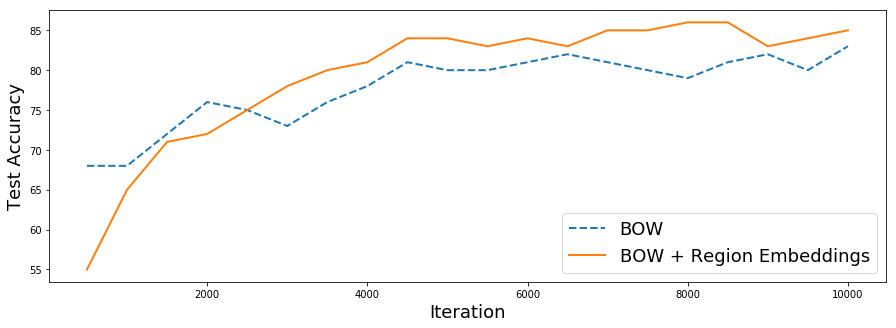

In [17]:
naive_test_accuracy = [68.0, 68.0, 72.0, 76.0, 75.0, 73.0, 76.0, 78.0, 81.0, 80.0, 80.0, 81.0, 82.0, 81.0, 80.0, 79.0, 81.0, 82.0, 80.0, 83.0]
reg_test_accuracy = [55.0, 65.0, 71.0, 72.0, 75.0, 78.0, 80.0, 81.0, 84.0, 84.0, 83.0, 84.0, 83.0, 85.0, 85.0, 86.0, 86.0, 83.0, 84.0, 85.0]

f = pylab.figure(figsize=(15,5))
pylab.plot(np.arange(500,10001,500),naive_test_accuracy, linestyle='--', linewidth = 2.0, label='BOW')
pylab.plot(np.arange(500,10001,500),reg_test_accuracy, linewidth = 2.0, label='BOW + Region Embeddings')
pylab.legend(fontsize=18)
pylab.xlabel('Iteration', fontsize=18)
pylab.ylabel('Test Accuracy', fontsize=18)
pylab.show()

